# PORTAFOLIOS TIPO MARKOWIT

En este notebook se generarán portofolios con acciones pertenecientes al S&P 500 con el fin de evaluar su desempeño por fuera de los datos de optimización.  Se utilizarán ventanas de optimización de 2 años y de pruebas de 6 meses

### Carga de Librerias

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import pandas as pd
import numpy as np
import scipy
from scipy.optimize import minimize
import scipy
import os
import pickle

import numpy as np 
from pandas import DataFrame
import matplotlib.pyplot as plt

import seaborn as sns

from matplotlib import rcParams
rcParams['figure.figsize'] = 11.7,8.27

%matplotlib inline

### Declaración de Funciones

In [2]:
def annualize_rets(r, periods_per_year):
    "anualiza retorns desde subperiodos de año"
    compounded_growth = np.prod(1+r)
    n_periods = r.shape[0]
    return compounded_growth**(periods_per_year / n_periods)-1

In [3]:
def carga_datos(path):
    df = pd.read_parquet(path)
    df.set_index('Date', inplace=True)
    return df

In [4]:
def portfolio_vol(weights, covmat):
    """
    weights -> volatility
    """
    return (weights.T @ covmat @ weights)**0.5

In [5]:
def portfolio_return(weights, returns):
    """
    weights -> Returns
    """
    return weights.T @ returns  #matrix or vector multiplicacion 

In [6]:
def msr(riskfree_rate, er, cov):
    """
    f(riskfree_rate, ER, cov) -> w
    """
    n = er.shape[0]
    init_guess = np.repeat(1/n, n)
    bounds = ((0.0, 1.0),) * n # an N-tuple of 2-tuples!
    # construct the constraints
    weights_sum_to_1 = {'type': 'eq',
                        'fun': lambda weights: np.sum(weights) - 1
    }
    
    def neg_sharpe_ratio(weights, riskfree_rate, er, cov):
        """
        negative sharpe_ratio
        """
        r = portfolio_return(weights, er)
        vol = portfolio_vol(weights, cov)
        return -(r-riskfree_rate)/vol
    
    
    weights = scipy.optimize.minimize(fun = neg_sharpe_ratio, x0 = init_guess, args = (riskfree_rate, er, cov,),
                       method='SLSQP',
                       options={'disp': False},
                       constraints=(weights_sum_to_1),
                       bounds=bounds)
    return weights.x

In [7]:
def portafolio_markowitz(datos, dias_trading, rf):
    cov = datos.cov()
    anual_returns = annualize_rets(datos1, dias_trading)
    pesos = msr(rf, anual_returns, cov)
    return pesos

### Carga de Datos para 1 periodo

Los datos contienen rendimientos para 465 acciones, la primera ventana de datos contiene 504 rendimientos diarios desde 01 de enero de 2013 hasta el 31 de diciembre de 2014.  Dos años.

In [8]:
datos1 = carga_datos('./Data/train/opt-20130101-20141231.gzip')

In [9]:
datos1.shape

(504, 465)

In [10]:
tickers1=datos1.columns
tickers1

Index(['A', 'AAL', 'AAP', 'AAPL', 'ABC', 'ABMD', 'ABT', 'ACN', 'ADBE', 'ADI',
       ...
       'XEL', 'XLNX', 'XOM', 'XRAY', 'XRX', 'XYL', 'YUM', 'ZBH', 'ZBRA',
       'ZION'],
      dtype='object', name='Stock', length=465)

In [11]:
datos1.head()

Stock,A,AAL,AAP,AAPL,ABC,ABMD,ABT,ACN,ADBE,ADI,...,XEL,XLNX,XOM,XRAY,XRX,XYL,YUM,ZBH,ZBRA,ZION
Date,,,,,,,,,,,,,,,,,,,,,
2013-01-02,0.022960,0.035556,0.001935,0.031681,0.007179,0.018601,0.019827,0.038496,0.017516,0.046125,...,0.025084,0.034300,0.024957,0.022974,0.054252,0.014760,0.011446,0.015602,0.041974,0.027570
2013-01-03,0.003582,-0.022890,0.000000,-0.012622,-0.002070,-0.017531,0.038065,-0.003620,-0.015389,-0.016137,...,-0.002922,-0.001887,-0.001803,-0.002715,0.000000,-0.003273,0.006254,0.014328,0.000977,0.001364
2013-01-04,0.019748,0.078331,0.015589,-0.027855,0.006682,-0.002974,-0.006011,0.005522,0.010066,-0.017787,...,0.003663,-0.014047,0.004630,0.008661,-0.011126,-0.001459,0.010950,0.005097,-0.008049,0.028611
2013-01-07,-0.007233,0.007468,-0.003396,-0.005882,0.003205,-0.011931,0.008164,-0.004336,-0.004983,0.003057,...,-0.010584,-0.004110,-0.011578,0.003435,0.016877,-0.013153,-0.006294,0.002463,0.005655,-0.004857
2013-01-08,-0.007991,0.021563,-0.016356,0.002691,-0.001369,-0.003019,0.000300,0.005806,0.005272,-0.010317,...,0.001844,-0.020358,0.006255,-0.011492,-0.001383,-0.012218,-0.041980,0.001445,0.000733,-0.019964


In [12]:
datos1.tail(2)

Stock,A,AAL,AAP,AAPL,ABC,ABMD,ABT,ACN,ADBE,ADI,...,XEL,XLNX,XOM,XRAY,XRX,XYL,YUM,ZBH,ZBRA,ZION
Date,,,,,,,,,,,,,,,,,,,,,
2014-12-30,0.000968,0.010785,-0.007381,-0.012203,-0.00382,-0.003118,0.001974,-0.003646,-0.014164,-0.009272,...,-0.023356,-0.005481,-0.000537,-0.007258,-0.009194,-0.011065,-0.003806,0.009427,0.003459,-0.001741
2014-12-31,-0.010394,0.003931,-0.004687,-0.019019,-0.01227,-0.007821,-0.014664,-0.009757,-0.005200,-0.000720,...,-0.012645,-0.005970,-0.006128,-0.001312,-0.010706,-0.009368,-0.005868,-0.010038,-0.011619,-0.005581


### Calculo del Portafolio para 1 periodo

In [13]:
cov1 = datos1.cov()

In [14]:
cov1

Stock,A,AAL,AAP,AAPL,ABC,ABMD,ABT,ACN,ADBE,ADI,...,XEL,XLNX,XOM,XRAY,XRX,XYL,YUM,ZBH,ZBRA,ZION
Stock,,,,,,,,,,,,,,,,,,,,,
A,0.000194,0.000095,0.000064,0.000033,0.000045,0.000058,0.000062,0.000067,0.000072,0.000082,...,0.000025,0.000081,0.000048,0.000065,0.000087,0.000090,0.000069,0.000068,0.000080,0.000084
AAL,0.000095,0.000555,0.000073,0.000037,0.000061,0.000104,0.000049,0.000069,0.000106,0.000081,...,0.000027,0.000069,0.000030,0.000071,0.000080,0.000099,0.000083,0.000066,0.000100,0.000085
AAP,0.000064,0.000073,0.000241,0.000026,0.000038,0.000063,0.000059,0.000044,0.000067,0.000050,...,0.000030,0.000055,0.000030,0.000042,0.000063,0.000053,0.000052,0.000045,0.000048,0.000055
AAPL,0.000033,0.000037,0.000026,0.000255,0.000010,0.000029,0.000018,0.000025,0.000029,0.000048,...,0.000010,0.000020,0.000017,0.000024,0.000041,0.000036,0.000031,0.000052,0.000038,0.000035
ABC,0.000045,0.000061,0.000038,0.000010,0.000095,0.000065,0.000044,0.000037,0.000048,0.000040,...,0.000024,0.000033,0.000029,0.000042,0.000044,0.000042,0.000036,0.000040,0.000033,0.000047
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
XYL,0.000090,0.000099,0.000053,0.000036,0.000042,0.000078,0.000046,0.000059,0.000092,0.000082,...,0.000022,0.000087,0.000058,0.000063,0.000089,0.000251,0.000081,0.000060,0.000064,0.000081
YUM,0.000069,0.000083,0.000052,0.000031,0.000036,0.000061,0.000041,0.000045,0.000068,0.000056,...,0.000028,0.000051,0.000044,0.000049,0.000057,0.000081,0.000184,0.000049,0.000043,0.000064
ZBH,0.000068,0.000066,0.000045,0.000052,0.000040,0.000068,0.000061,0.000048,0.000054,0.000056,...,0.000031,0.000032,0.000041,0.000056,0.000076,0.000060,0.000049,0.000144,0.000060,0.000055


In [15]:
anual_returns = annualize_rets(datos1, 253)
anual_returns

Stock
A       0.193463
AAL     1.003660
AAP     0.489474
AAPL    0.233786
ABC     0.468110
          ...   
XYL     0.204535
YUM     0.069134
ZBH     0.319408
ZBRA    0.405177
ZION    0.160795
Length: 465, dtype: float64

Asumiendo una tasa libre de riesgo del 2%, se obtienen los pesos con el método de media varianza de Markowitzs

In [16]:
pesos1 = msr(0.02, anual_returns, cov1)

In [17]:
pesos1[0:10]

array([0.00000000e+00, 3.50119845e-10, 7.68373040e-10, 9.37324437e-10,
       5.81783430e-02, 9.06382370e-10, 3.06900863e-10, 0.00000000e+00,
       6.06100990e-11, 0.00000000e+00])

In [18]:
pesos1.shape

(465,)

Existe otra función que integra todo los anteriores calculos para los pesos optimos de markowitz.  Equivale al portafolio que maximiza el sharpe ratio.  El parametro de dias de trading se refiere al numero de dias habiles de tradin en un año

In [19]:
pesos2 = portafolio_markowitz(datos1, dias_trading=253, rf=0.02)

In [20]:
pesos2

array([0.00000000e+00, 3.50119845e-10, 7.68373040e-10, 9.37324437e-10,
       5.81783430e-02, 9.06382370e-10, 3.06900863e-10, 0.00000000e+00,
       6.06100990e-11, 0.00000000e+00, 9.61104147e-10, 5.23200163e-10,
       0.00000000e+00, 1.44311720e-09, 1.32632302e-09, 6.10831805e-11,
       0.00000000e+00, 0.00000000e+00, 9.93236172e-10, 6.50306708e-10,
       1.29925251e-10, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 8.44368651e-10, 0.00000000e+00, 2.69087153e-10,
       8.91540624e-02, 0.00000000e+00, 0.00000000e+00, 2.15322769e-10,
       0.00000000e+00, 3.82992374e-10, 0.00000000e+00, 0.00000000e+00,
       9.82750336e-10, 3.56663819e-10, 0.00000000e+00, 0.00000000e+00,
       4.40979606e-10, 0.00000000e+00, 0.00000000e+00, 8.65200968e-10,
       1.20526634e-09, 1.37900834e-10, 8.52805116e-10, 9.25942215e-10,
       0.00000000e+00, 1.30594091e-09, 0.00000000e+00, 8.25861613e-10,
       3.91862237e-10, 0.00000000e+00, 8.78550393e-12, 1.78501754e-03,
      

In [21]:
pesos_cero = (pesos2 == 0).sum()
pesos_cero

205

muchos pesos no son cero pero si cercanos a cero.  se aproximan a cero los pesos que no superan un limite

In [22]:
pesos3 = np.where(pesos2<1e-8,0,pesos2)

In [23]:
pesos3.sum()

0.9999999883917394

In [24]:
pesos3

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       5.81783430e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       8.91540624e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.78501754e-03,
      

In [25]:
#ajuste pesos
const = pesos3.sum()
pesos3 = pesos3*(1/const)

In [26]:
pesos_cero = (pesos3 == 0).sum()
pesos_cero

448

In [27]:
pesos_non_cero = (pesos3 != 0).sum()
pesos_non_cero

17

In [28]:
pesos3.sum()

1.0

En la respuesta obtenida se puede observar que del total de 465 acciones, el método de markowitzs incluye 17 acciones en el portafolio óptimo y excluye de la solución a 448 acciones.    Este porfafolio en la literatura manifiestan que presentan los siguientes problemas

* Concentración de activos
* tiene en cuenta los rendimientos esperados, variable que se considera no predecible
* El costo de rebalanceo puede ser alto pues usualmente cambia de activos


### Carga de datos para todos los periodos

In [29]:
#cargar nombres y rutas de los archivos de entrenamiento
archivos = []
path_train = "./Data/train/"
for root, dirs, files in os.walk("./Data/train/"):
    for filename in files:
        temp = path_train + filename
        archivos.append(temp)

Hay un total de 24 periodos de entrenamiento

In [30]:
archivos = archivos[:-1]
archivos

['./Data/train/opt-20130101-20141231.gzip',
 './Data/train/opt-20130401-20150331.gzip',
 './Data/train/opt-20130701-20150630.gzip',
 './Data/train/opt-20131001-20150930.gzip',
 './Data/train/opt-20140101-20151231.gzip',
 './Data/train/opt-20140401-20160331.gzip',
 './Data/train/opt-20140701-20160630.gzip',
 './Data/train/opt-20141001-20160930.gzip',
 './Data/train/opt-20150101-20161231.gzip',
 './Data/train/opt-20150401-20170331.gzip',
 './Data/train/opt-20150701-20170630.gzip',
 './Data/train/opt-20151001-20170930.gzip',
 './Data/train/opt-20160101-20171231.gzip',
 './Data/train/opt-20160401-20180331.gzip',
 './Data/train/opt-20160701-20180630.gzip',
 './Data/train/opt-20161001-20180930.gzip',
 './Data/train/opt-20170101-20181231.gzip',
 './Data/train/opt-20170401-20190331.gzip',
 './Data/train/opt-20170701-20190630.gzip',
 './Data/train/opt-20171001-20190930.gzip',
 './Data/train/opt-20180101-20191231.gzip',
 './Data/train/opt-20180401-20200331.gzip',
 './Data/train/opt-20180701-2020

In [31]:
datos_train = pd.DataFrame()
for file in archivos:
    datos_temp = carga_datos(file)
    tickers_temp = datos_temp.columns
    portafolio_file = portafolio_markowitz(datos_temp, dias_trading=253, rf=0.02)
    portafolio_file1 = np.where(portafolio_file<1e-8,0,portafolio_file)
    const = portafolio_file1.sum()
    portafolio_file1 = portafolio_file1*(1/const)
    portfolio_df = pd.DataFrame(portafolio_file1).transpose()
    portfolio_df.columns = tickers_temp
    datos_train = datos_train.append(portfolio_df)
    datos_train = datos_train.reset_index(drop=True)
    datos_train.index.names = ['portafolio']

In [32]:
datos_train

Stock,A,AAL,AAP,AAPL,ABC,ABMD,ABT,ACN,ADBE,ADI,...,XEL,XLNX,XOM,XRAY,XRX,XYL,YUM,ZBH,ZBRA,ZION
portafolio,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.000000e+00,0.0,5.817834e-02,0.000000,0.0,0.0,0.0,0.0,...,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.000000e+00,0.0,4.744839e-02,0.000000,0.0,0.0,0.0,0.0,...,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.000000e+00,0.0,4.150915e-03,0.008409,0.0,0.0,0.0,0.0,...,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.000000e+00,0.0,0.000000e+00,0.008053,0.0,0.0,0.0,0.0,...,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.000000e+00,0.0,2.969671e-02,0.008247,0.0,0.0,0.0,0.0,...,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.000000e+00,0.0,4.276132e-02,0.000000,0.0,0.0,0.0,0.0,...,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.000000e+00,0.0,2.617502e-03,0.000000,0.0,0.0,0.0,0.0,...,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.000000e+00,0.0,1.114229e-08,0.000000,0.0,0.0,0.0,0.0,...,1.080419e-08,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.000000e+00,0.0,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,...,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0


In [33]:
datos_train.to_csv('./salida/portafolios_markowitz.csv')

## Evaluación Fuera de la Muestra

In [34]:
pesos_markowitz = pd.read_csv('./salida/portafolios_markowitz.csv', index_col='portafolio')

In [35]:
pesos_markowitz

,A,AAL,AAP,AAPL,ABC,ABMD,ABT,ACN,ADBE,ADI,...,XEL,XLNX,XOM,XRAY,XRX,XYL,YUM,ZBH,ZBRA,ZION
portafolio,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.000000e+00,0.0,5.817834e-02,0.000000,0.0,0.0,0.0,0.0,...,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.000000e+00,0.0,4.744839e-02,0.000000,0.0,0.0,0.0,0.0,...,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.000000e+00,0.0,4.150915e-03,0.008409,0.0,0.0,0.0,0.0,...,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.000000e+00,0.0,0.000000e+00,0.008053,0.0,0.0,0.0,0.0,...,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.000000e+00,0.0,2.969671e-02,0.008247,0.0,0.0,0.0,0.0,...,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.000000e+00,0.0,4.276132e-02,0.000000,0.0,0.0,0.0,0.0,...,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.000000e+00,0.0,2.617502e-03,0.000000,0.0,0.0,0.0,0.0,...,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.000000e+00,0.0,1.114229e-08,0.000000,0.0,0.0,0.0,0.0,...,1.080419e-08,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.000000e+00,0.0,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,...,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0


In [36]:
pesos_markowitz.loc[0]

A       0.000000
AAL     0.000000
AAP     0.000000
AAPL    0.000000
ABC     0.058178
          ...   
XYL     0.000000
YUM     0.000000
ZBH     0.000000
ZBRA    0.000000
ZION    0.000000
Name: 0, Length: 465, dtype: float64

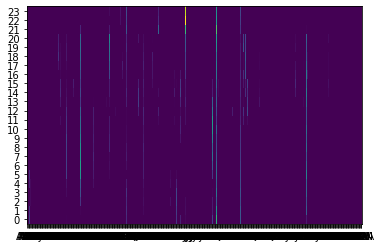

In [37]:
plt.pcolor(pesos_markowitz)
plt.yticks(np.arange(0.5, len(pesos_markowitz.index), 1), pesos_markowitz.index)
plt.xticks(np.arange(0.5, len(pesos_markowitz.columns), 1), pesos_markowitz.columns)
plt.show()

<AxesSubplot:ylabel='portafolio'>

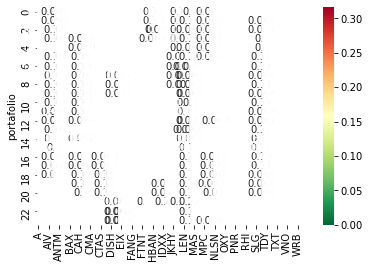

In [38]:
sns.heatmap(pesos_markowitz, cmap='RdYlGn_r', linewidths=0.5, annot=True)

In [39]:
def media_vol_portafolio(retornos, pesos, rf=0.02):
    r = annualize_rets(retornos, 253)
    retor = portfolio_return(pesos, r)
    cova = retornos.cov()
    vola = portfolio_vol(pesos, cova)
    vola = vola*np.sqrt(253)
    sharpe = (retor - rf)/vola
    return {"retorno_anual_markowitz":retor, "desviacion_estandar_anual_markowitz":vola, "sharpe_ratio_markowitz":sharpe}

In [40]:
prueba1 = carga_datos('./Data/test/pereval-20150101-20150331.gzip')

In [41]:
prueba1.shape

(61, 465)

In [42]:
media_vol_portafolio(prueba1, pesos_markowitz.loc[0])

{'retorno_anual_markowitz': 0.5859873139902108,
 'desviacion_estandar_anual_markowitz': 0.16669309012298136,
 'sharpe_ratio_markowitz': 3.395385577006471}

In [43]:
## calculo para todos los portafolios de prueba

archivosT = []
path_trainT = "./Data/test/"
for root, dirs, files in os.walk("./Data/test/"):
    for filename in files:
        if 'gzip' in filename:
            temp = path_trainT + filename
            archivosT.append(temp)

archivosT

['./Data/test/pereval-20150101-20150331.gzip',
 './Data/test/pereval-20150401-20150630.gzip',
 './Data/test/pereval-20150701-20150930.gzip',
 './Data/test/pereval-20151001-20151231.gzip',
 './Data/test/pereval-20160101-20160331.gzip',
 './Data/test/pereval-20160401-20160630.gzip',
 './Data/test/pereval-20160701-20160930.gzip',
 './Data/test/pereval-20161001-20161231.gzip',
 './Data/test/pereval-20170101-20170331.gzip',
 './Data/test/pereval-20170401-20170630.gzip',
 './Data/test/pereval-20170701-20170930.gzip',
 './Data/test/pereval-20171001-20171231.gzip',
 './Data/test/pereval-20180101-20180331.gzip',
 './Data/test/pereval-20180401-20180630.gzip',
 './Data/test/pereval-20180701-20180930.gzip',
 './Data/test/pereval-20181001-20181231.gzip',
 './Data/test/pereval-20190101-20190331.gzip',
 './Data/test/pereval-20190401-20190630.gzip',
 './Data/test/pereval-20190701-20190930.gzip',
 './Data/test/pereval-20191001-20191231.gzip',
 './Data/test/pereval-20200101-20200331.gzip',
 './Data/test

           three-month U.S. Treasury bill
Trimestre                                
20150101                           0.0002
20150401                           0.0003
20150701                           0.0001
20151001                           0.0000
20160101                           0.0022
20160401                           0.0023
20160701                           0.0028
20161001                           0.0032
20170101                           0.0053
20170401                           0.0079
20170701                           0.0106
20171001                           0.0101
20180101                           0.0144
20180401                           0.0177
20180701                           0.0198
20181001                           0.0223
20190101                           0.0240
20190401                           0.0243
20190701                           0.0221
20191001                           0.0182
20200101                           0.0155
20200401                          

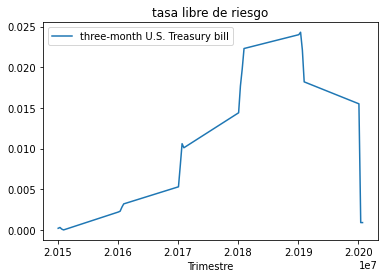

In [44]:
#carga de rf
rfT = pd.read_csv('./Data/rf_test.csv')
rfT = rfT.set_index('Trimestre')
rfT.plot(title='tasa libre de riesgo')
print(rfT)

In [45]:
resultadosT = []
for i in range(len(archivos)-1):
    data = carga_datos(archivosT[i])
    print(archivosT[i].split('/')[3].split('-')[1])
    salida = media_vol_portafolio(data, pesos_markowitz.loc[i], rfT.iloc[i]['three-month U.S. Treasury bill'])
    salida['trimeste_inicia'] = archivosT[i].split('/')[3].split('-')[1]
    resultadosT.append(salida)

20150101
20150401
20150701
20151001
20160101
20160401
20160701
20161001
20170101
20170401
20170701
20171001
20180101
20180401
20180701
20181001
20190101
20190401
20190701
20191001
20200101
20200401
20200701


In [46]:
resultadosT = pd.DataFrame(resultadosT)
resultadosT = resultadosT.set_index('trimeste_inicia')

In [47]:
resultadosT

,retorno_anual_markowitz,desviacion_estandar_anual_markowitz,sharpe_ratio_markowitz
trimeste_inicia,,,
20150101,0.585987,0.166693,3.514167
20150401,-0.021648,0.128258,-0.171123
20150701,0.027298,0.189605,0.143446
20151001,0.291799,0.140368,2.078819
20160101,0.085205,0.196617,0.422167
20160401,0.254669,0.116788,2.160918
20160701,0.219114,0.105868,2.043249
20161001,0.362199,0.094618,3.794198
20170101,0.487498,0.090051,5.354727


<AxesSubplot:title={'center':'sharpe ratio portafolio Markowitz'}, xlabel='trimeste_inicia'>

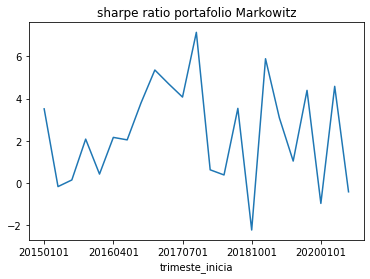

In [48]:
resultadosT['sharpe_ratio_markowitz'].plot(title='sharpe ratio portafolio Markowitz')

In [49]:
sharpe_medio = resultadosT['sharpe_ratio_markowitz'].mean()
print(f'Por fuera de la muestra el sharpe medio fue de {sharpe_medio}')

Por fuera de la muestra el sharpe medio fue de 2.398353830256782


### Calculos de Shape Ratio si se hubiese invertido en el índice S&P 500 cada trimestre

In [50]:
data_syp = pd.read_csv('./Data/GSPC.csv')
data_syp.head()

,Date,Trimestre,Retorno
0,2/01/2015,20150101,-0.000340
1,5/01/2015,20150101,-0.018278
2,6/01/2015,20150101,-0.008893
3,7/01/2015,20150101,0.011630
4,8/01/2015,20150101,0.017888


In [51]:
data_syp.dtypes

Date          object
Trimestre      int64
Retorno      float64
dtype: object

In [52]:
data_syp['Trimestre'] = data_syp['Trimestre'].astype(str)

In [53]:
#listado de trimestres
trimestres = resultadosT.index.to_list()
trimestres

['20150101',
 '20150401',
 '20150701',
 '20151001',
 '20160101',
 '20160401',
 '20160701',
 '20161001',
 '20170101',
 '20170401',
 '20170701',
 '20171001',
 '20180101',
 '20180401',
 '20180701',
 '20181001',
 '20190101',
 '20190401',
 '20190701',
 '20191001',
 '20200101',
 '20200401',
 '20200701']

In [54]:
data_syp[data_syp['Trimestre']=='20150101']


,Date,Trimestre,Retorno
0,2/01/2015,20150101,-0.000340
1,5/01/2015,20150101,-0.018278
2,6/01/2015,20150101,-0.008893
3,7/01/2015,20150101,0.011630
4,8/01/2015,20150101,0.017888
...,...,...,...
56,25/03/2015,20150101,-0.014559
57,26/03/2015,20150101,-0.002377
58,27/03/2015,20150101,0.002369
59,30/03/2015,20150101,0.012237


In [55]:
data_syp_list = []
for i, trim in enumerate(trimestres):
    #print (i)
    #print(trim)
    rent_syp = data_syp[data_syp['Trimestre']==trim]['Retorno']
    rend = annualize_rets(rent_syp, 253)
    #print (rend)
    vol = rent_syp.std()*np.sqrt(253)
    #print (vol)
    sharpe_syp =  (rend - rfT.iloc[i]['three-month U.S. Treasury bill'])/vol
    #print (sharpe_syp)
    data_syp_list.append([trim,rend,vol,sharpe_syp])


           
data_syp_list

[['20150101', 0.018234596161353922, 0.1416702803584778, 0.12729978451175344],
 ['20150401',
  -0.009250127561924448,
  0.10127516731344913,
  -0.09429880804211924],
 ['20150701', -0.24732822972816515, 0.21009627990764568, -1.17768972319229],
 ['20151001', 0.2804638137430482, 0.14874602763264427, 1.8855213695904893],
 ['20160101', 0.032453473414062683, 0.18566135222258404, 0.16294976338313355],
 ['20160401', 0.07721241248397215, 0.13695679229511118, 0.5469784391748362],
 ['20160701', 0.13725315249038617, 0.09842176058656488, 1.3660917228983178],
 ['20161001', 0.13723921814413398, 0.08611313222861146, 1.5565479349687255],
 ['20170101', 0.24580726051419655, 0.06714484819868471, 3.5819168106914834],
 ['20170401', 0.10721853793883751, 0.07368245273986959, 1.3479265991520966],
 ['20170701', 0.16874871695704763, 0.07126967672512843, 2.2190183009668005],
 ['20171001', 0.2695241144183944, 0.05571772742816538, 4.656042634776507],
 ['20180101', -0.04981892661541243, 0.19889596913420626, -0.322876

In [56]:
data_syp_list_df = pd.DataFrame(data_syp_list, columns=['trimeste_inicia','retorno_anual_syp',
                                                        'desviacion_estandar_anual_syp','sharpe_ratio_syp'])
data_syp_list_df = data_syp_list_df.set_index('trimeste_inicia')
data_syp_list_df

,retorno_anual_syp,desviacion_estandar_anual_syp,sharpe_ratio_syp
trimeste_inicia,,,
20150101,0.018235,0.141670,0.127300
20150401,-0.009250,0.101275,-0.094299
20150701,-0.247328,0.210096,-1.177690
20151001,0.280464,0.148746,1.885521
20160101,0.032453,0.185661,0.162950
20160401,0.077212,0.136957,0.546978
20160701,0.137253,0.098422,1.366092
20161001,0.137239,0.086113,1.556548
20170101,0.245807,0.067145,3.581917


<AxesSubplot:title={'center':'Shape Ratio del S&P'}, xlabel='trimeste_inicia'>

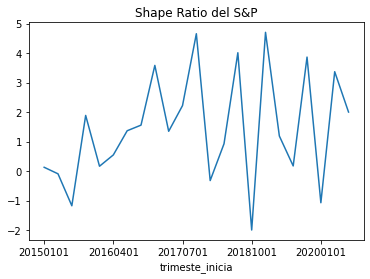

In [57]:
data_syp_list_df['sharpe_ratio_syp'].plot(title='Shape Ratio del S&P')

In [58]:
shape_mark_syp_df = pd.concat([resultadosT, data_syp_list_df], axis=1)
shape_mark_syp_df

,retorno_anual_markowitz,desviacion_estandar_anual_markowitz,sharpe_ratio_markowitz,retorno_anual_syp,desviacion_estandar_anual_syp,sharpe_ratio_syp
trimeste_inicia,,,,,,
20150101,0.585987,0.166693,3.514167,0.018235,0.141670,0.127300
20150401,-0.021648,0.128258,-0.171123,-0.009250,0.101275,-0.094299
20150701,0.027298,0.189605,0.143446,-0.247328,0.210096,-1.177690
20151001,0.291799,0.140368,2.078819,0.280464,0.148746,1.885521
20160101,0.085205,0.196617,0.422167,0.032453,0.185661,0.162950
20160401,0.254669,0.116788,2.160918,0.077212,0.136957,0.546978
20160701,0.219114,0.105868,2.043249,0.137253,0.098422,1.366092
20161001,0.362199,0.094618,3.794198,0.137239,0.086113,1.556548
20170101,0.487498,0.090051,5.354727,0.245807,0.067145,3.581917


In [59]:
shape_mark_syp_df

,retorno_anual_markowitz,desviacion_estandar_anual_markowitz,sharpe_ratio_markowitz,retorno_anual_syp,desviacion_estandar_anual_syp,sharpe_ratio_syp
trimeste_inicia,,,,,,
20150101,0.585987,0.166693,3.514167,0.018235,0.141670,0.127300
20150401,-0.021648,0.128258,-0.171123,-0.009250,0.101275,-0.094299
20150701,0.027298,0.189605,0.143446,-0.247328,0.210096,-1.177690
20151001,0.291799,0.140368,2.078819,0.280464,0.148746,1.885521
20160101,0.085205,0.196617,0.422167,0.032453,0.185661,0.162950
20160401,0.254669,0.116788,2.160918,0.077212,0.136957,0.546978
20160701,0.219114,0.105868,2.043249,0.137253,0.098422,1.366092
20161001,0.362199,0.094618,3.794198,0.137239,0.086113,1.556548
20170101,0.487498,0.090051,5.354727,0.245807,0.067145,3.581917


<AxesSubplot:xlabel='trimeste_inicia'>

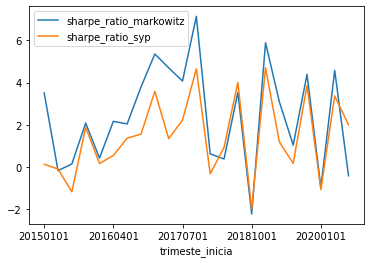

In [60]:
shape_mark_syp_df[['sharpe_ratio_markowitz','sharpe_ratio_syp']].plot()

In [61]:
sharpe_medio_syp = shape_mark_syp_df['sharpe_ratio_syp'].mean()
print(f'En el periodo de prueba, el sharpe ratio promedio del S&P due {sharpe_medio_syp}')

En el periodo de prueba, el sharpe ratio promedio del S&P due 1.4353600252186767


<AxesSubplot:>

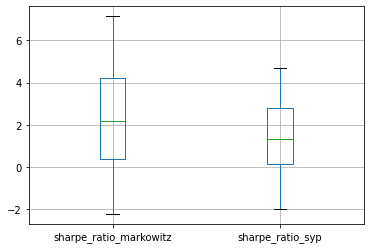

In [62]:
shape_mark_syp_df[['sharpe_ratio_markowitz','sharpe_ratio_syp']].boxplot()

In [63]:
def year2trim(rate):
    trim_rate = (1+rate)**(1/4)-1
    return trim_rate

In [64]:
year2trim(0.1)

0.02411368908444511

In [65]:
rendimientos_acu = shape_mark_syp_df[['retorno_anual_markowitz','retorno_anual_syp']]

In [66]:
rendimientos_acu.head()

,retorno_anual_markowitz,retorno_anual_syp
trimeste_inicia,,
20150101,0.585987,0.018235
20150401,-0.021648,-0.009250
20150701,0.027298,-0.247328
20151001,0.291799,0.280464
20160101,0.085205,0.032453


In [67]:
rendimientos_acu['retorno_trim_markowitz'] = rendimientos_acu['retorno_anual_markowitz'].apply(year2trim)
rendimientos_acu['retorno_trim_syp'] = rendimientos_acu['retorno_anual_syp'].apply(year2trim)

<ipython-input-67-dd60bd14d6f9>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rendimientos_acu['retorno_trim_markowitz'] = rendimientos_acu['retorno_anual_markowitz'].apply(year2trim)
<ipython-input-67-dd60bd14d6f9>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rendimientos_acu['retorno_trim_syp'] = rendimientos_acu['retorno_anual_syp'].apply(year2trim)


In [68]:
rendimientos_acu.head()

,retorno_anual_markowitz,retorno_anual_syp,retorno_trim_markowitz,retorno_trim_syp
trimeste_inicia,,,,
20150101,0.585987,0.018235,0.122212,0.004528
20150401,-0.021648,-0.009250,-0.005456,-0.002321
20150701,0.027298,-0.247328,0.006756,-0.068567
20151001,0.291799,0.280464,0.066102,0.063756
20160101,0.085205,0.032453,0.020653,0.008016


In [69]:
rendimientos_acu['retorno_trim_acum_markowitz'] = (rendimientos_acu['retorno_trim_markowitz']+1).cumprod()
rendimientos_acu['retorno_trim_acum_syp'] = (rendimientos_acu['retorno_trim_syp']+1).cumprod()

<ipython-input-69-79d3e73d01d4>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rendimientos_acu['retorno_trim_acum_markowitz'] = (rendimientos_acu['retorno_trim_markowitz']+1).cumprod()


<AxesSubplot:title={'center':'Crecimiento del capital invertido'}, xlabel='trimeste_inicia'>

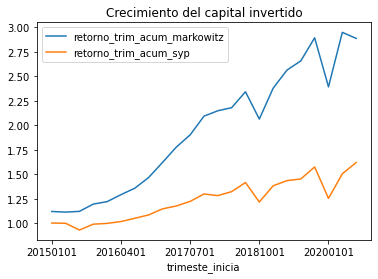

In [70]:
rendimientos_acu[['retorno_trim_acum_markowitz','retorno_trim_acum_syp']].plot(title='Crecimiento del capital invertido')

In [71]:
rendimientos_acu[['retorno_trim_acum_markowitz','retorno_trim_acum_syp']]

,retorno_trim_acum_markowitz,retorno_trim_acum_syp
trimeste_inicia,,
20150101,1.122212,1.004528
20150401,1.116089,1.002197
20150701,1.123629,0.933479
20151001,1.197903,0.992993
20160101,1.222643,1.000953
20160401,1.293993,1.019739
20160701,1.359700,1.053061
20161001,1.468937,1.087468
20170101,1.622248,1.148892


### Portafolios 130/30

In [198]:
pesos_DE = pd.read_csv('./salida/portfolios_DE.csv')

In [199]:
pesos_DE

,A,AAL,AAP,AAPL,ABC,ABMD,ABT,ACN,ADBE,ADI,...,XEL,XLNX,XOM,XRAY,XRX,XYL,YUM,ZBH,ZBRA,ZION
0,0.000000,0.034550,0.000000,0.000000,0.034550,0.000000,0.000000,0.000000,0.007556,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.035274,0.000000,0.000000,0.035274,0.035274,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.002104,0.000000,0.000000,0.000000,0.000000,0.006303,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.036854,0.000000,0.036854,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.036854,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.031753,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.031753,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.032032,0.000000,0.000000,0.000000,0.000000
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.034467,0.000000,0.000000,0.000000,0.034467,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.000000,0.000000,-0.004655,0.000000,0.000000,0.033153,0.000000,0.000000,0.033153,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,-0.000565,0.000000,0.000000,0.011768,0.000000,0.040568,-0.000565,0.000000,0.040568,0.000000,...,0.000000,-0.000565,0.000000,0.000196,0.000000,0.000000,0.000000,0.000196,0.000196,0.000000
8,0.000000,0.000000,0.000000,0.000000,0.000000,0.037760,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,0.000189,0.000000,0.000000,0.000000,0.000000,0.000000,0.000189,0.000189,0.000189,0.000189,...,0.039498,0.000000,0.000000,0.000189,0.000189,0.039498,0.000000,0.000189,0.000000,0.000000


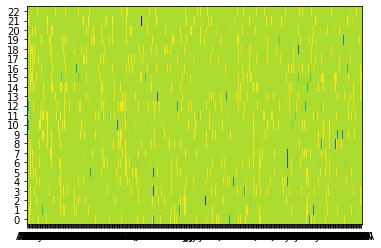

In [200]:
plt.pcolor(pesos_DE)
plt.yticks(np.arange(0.5, len(pesos_DE.index), 1), pesos_DE.index)
plt.xticks(np.arange(0.5, len(pesos_DE.columns), 1), pesos_DE.columns)
plt.show()

In [201]:
def media_vol_portafolioDE(retornos, pesos, rf=0.02):
    r = annualize_rets(retornos, 253)
    retor = portfolio_return(pesos, r)
    cova = retornos.cov()
    vola = portfolio_vol(pesos, cova)
    vola = vola*np.sqrt(253)
    sharpe = (retor - rf)/vola
    return {"retorno_anual_DE":retor, "desviacion_estandar_anual_DE":vola, "sharpe_ratio_DE":sharpe}

In [202]:
prueba1 = carga_datos('./Data/test/pereval-20150101-20150331.gzip')

In [203]:
media_vol_portafolioDE(prueba1, pesos_DE.loc[0], 0)

{'retorno_anual_DE': 0.2696159962486544,
 'desviacion_estandar_anual_DE': 0.16409693843560763,
 'sharpe_ratio_DE': 1.6430288024809976}

In [204]:
archivosT

['./Data/test/pereval-20150101-20150331.gzip',
 './Data/test/pereval-20150401-20150630.gzip',
 './Data/test/pereval-20150701-20150930.gzip',
 './Data/test/pereval-20151001-20151231.gzip',
 './Data/test/pereval-20160101-20160331.gzip',
 './Data/test/pereval-20160401-20160630.gzip',
 './Data/test/pereval-20160701-20160930.gzip',
 './Data/test/pereval-20161001-20161231.gzip',
 './Data/test/pereval-20170101-20170331.gzip',
 './Data/test/pereval-20170401-20170630.gzip',
 './Data/test/pereval-20170701-20170930.gzip',
 './Data/test/pereval-20171001-20171231.gzip',
 './Data/test/pereval-20180101-20180331.gzip',
 './Data/test/pereval-20180401-20180630.gzip',
 './Data/test/pereval-20180701-20180930.gzip',
 './Data/test/pereval-20181001-20181231.gzip',
 './Data/test/pereval-20190101-20190331.gzip',
 './Data/test/pereval-20190401-20190630.gzip',
 './Data/test/pereval-20190701-20190930.gzip',
 './Data/test/pereval-20191001-20191231.gzip',
 './Data/test/pereval-20200101-20200331.gzip',
 './Data/test

In [205]:
pesos_DE

,A,AAL,AAP,AAPL,ABC,ABMD,ABT,ACN,ADBE,ADI,...,XEL,XLNX,XOM,XRAY,XRX,XYL,YUM,ZBH,ZBRA,ZION
0,0.000000,0.034550,0.000000,0.000000,0.034550,0.000000,0.000000,0.000000,0.007556,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.035274,0.000000,0.000000,0.035274,0.035274,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.002104,0.000000,0.000000,0.000000,0.000000,0.006303,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.036854,0.000000,0.036854,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.036854,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.031753,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.031753,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.032032,0.000000,0.000000,0.000000,0.000000
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.034467,0.000000,0.000000,0.000000,0.034467,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.000000,0.000000,-0.004655,0.000000,0.000000,0.033153,0.000000,0.000000,0.033153,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,-0.000565,0.000000,0.000000,0.011768,0.000000,0.040568,-0.000565,0.000000,0.040568,0.000000,...,0.000000,-0.000565,0.000000,0.000196,0.000000,0.000000,0.000000,0.000196,0.000196,0.000000
8,0.000000,0.000000,0.000000,0.000000,0.000000,0.037760,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,0.000189,0.000000,0.000000,0.000000,0.000000,0.000000,0.000189,0.000189,0.000189,0.000189,...,0.039498,0.000000,0.000000,0.000189,0.000189,0.039498,0.000000,0.000189,0.000000,0.000000


In [206]:
media_vol_portafolioDE(carga_datos(archivosT[0]), pesos_DE.loc[0], rfT.iloc[0]['three-month U.S. Treasury bill'])

{'retorno_anual_DE': 0.2696159962486544,
 'desviacion_estandar_anual_DE': 0.16409693843560763,
 'sharpe_ratio_DE': 1.6418100106990994}

In [207]:
media_vol_portafolioDE(carga_datos(archivosT[1]), pesos_DE.loc[1], rfT.iloc[1]['three-month U.S. Treasury bill'])

{'retorno_anual_DE': 0.08267705653481025,
 'desviacion_estandar_anual_DE': 0.11947265332612782,
 'sharpe_ratio_DE': 0.6895055415731274}

In [208]:
len(archivos)-1

23

In [209]:
resultadosDE = []
for i in range(len(archivos)-1):
    data = carga_datos(archivosT[i])
    print(archivosT[i].split('/')[3].split('-')[1])
    salidaDE = media_vol_portafolioDE(data, pesos_DE.loc[i], rfT.iloc[i]['three-month U.S. Treasury bill'])
    salidaDE['trimeste_inicia'] = archivosT[i].split('/')[3].split('-')[1]
    resultadosDE.append(salidaDE)

20150101
20150401
20150701
20151001
20160101
20160401
20160701
20161001
20170101
20170401
20170701
20171001
20180101
20180401
20180701
20181001
20190101
20190401
20190701
20191001
20200101
20200401
20200701


In [210]:
resultadosDE

[{'retorno_anual_DE': 0.2696159962486544,
  'desviacion_estandar_anual_DE': 0.16409693843560763,
  'sharpe_ratio_DE': 1.6418100106990994,
  'trimeste_inicia': '20150101'},
 {'retorno_anual_DE': 0.08267705653481025,
  'desviacion_estandar_anual_DE': 0.11947265332612782,
  'sharpe_ratio_DE': 0.6895055415731274,
  'trimeste_inicia': '20150401'},
 {'retorno_anual_DE': 0.10509318752385517,
  'desviacion_estandar_anual_DE': 0.24355184320564796,
  'sharpe_ratio_DE': 0.4310917385880838,
  'trimeste_inicia': '20150701'},
 {'retorno_anual_DE': 0.26147456733861374,
  'desviacion_estandar_anual_DE': 0.18487691991453045,
  'sharpe_ratio_DE': 1.414316981586965,
  'trimeste_inicia': '20151001'},
 {'retorno_anual_DE': 0.46168740137727904,
  'desviacion_estandar_anual_DE': 0.2241258620751185,
  'sharpe_ratio_DE': 2.0501311054557205,
  'trimeste_inicia': '20160101'},
 {'retorno_anual_DE': 0.22913531119238018,
  'desviacion_estandar_anual_DE': 0.15496713645405255,
  'sharpe_ratio_DE': 1.4637639720447206,

In [211]:
resultadosDE = pd.DataFrame(resultadosDE)

In [212]:
resultadosDE

,retorno_anual_DE,desviacion_estandar_anual_DE,sharpe_ratio_DE,trimeste_inicia
0,0.269616,0.164097,1.641810,20150101
1,0.082677,0.119473,0.689506,20150401
2,0.105093,0.243552,0.431092,20150701
3,0.261475,0.184877,1.414317,20151001
4,0.461687,0.224126,2.050131,20160101
5,0.229135,0.154967,1.463764,20160401
6,0.302954,0.127370,2.356558,20160701
7,0.260553,0.139613,1.843338,20161001
8,0.708400,0.115488,6.088065,20170101
9,0.455211,0.133663,3.346558,20170401


In [213]:
resultadosDE = resultadosDE.set_index('trimeste_inicia')

In [214]:
shape_mark_syp_DE_df = pd.concat([shape_mark_syp_df, resultadosDE], axis=1)
shape_mark_syp_DE_df

,retorno_anual_markowitz,desviacion_estandar_anual_markowitz,sharpe_ratio_markowitz,retorno_anual_syp,desviacion_estandar_anual_syp,sharpe_ratio_syp,retorno_anual_DE,desviacion_estandar_anual_DE,sharpe_ratio_DE
trimeste_inicia,,,,,,,,,
20150101,0.585987,0.166693,3.514167,0.018235,0.141670,0.127300,0.269616,0.164097,1.641810
20150401,-0.021648,0.128258,-0.171123,-0.009250,0.101275,-0.094299,0.082677,0.119473,0.689506
20150701,0.027298,0.189605,0.143446,-0.247328,0.210096,-1.177690,0.105093,0.243552,0.431092
20151001,0.291799,0.140368,2.078819,0.280464,0.148746,1.885521,0.261475,0.184877,1.414317
20160101,0.085205,0.196617,0.422167,0.032453,0.185661,0.162950,0.461687,0.224126,2.050131
20160401,0.254669,0.116788,2.160918,0.077212,0.136957,0.546978,0.229135,0.154967,1.463764
20160701,0.219114,0.105868,2.043249,0.137253,0.098422,1.366092,0.302954,0.127370,2.356558
20161001,0.362199,0.094618,3.794198,0.137239,0.086113,1.556548,0.260553,0.139613,1.843338
20170101,0.487498,0.090051,5.354727,0.245807,0.067145,3.581917,0.708400,0.115488,6.088065


<AxesSubplot:title={'center':'Comparacion de Sharpe Ratio'}, xlabel='trimeste_inicia'>

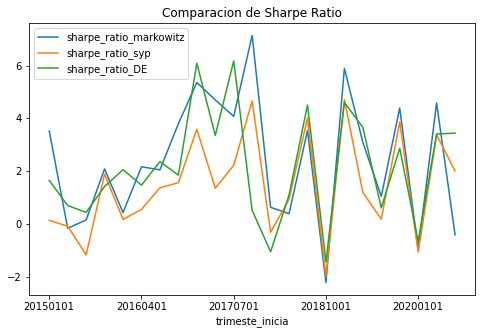

In [215]:
shape_mark_syp_DE_df[['sharpe_ratio_markowitz','sharpe_ratio_syp', 'sharpe_ratio_DE']].plot(figsize=(8, 5), title='Comparacion de Sharpe Ratio')

In [216]:
sharpe_medio_mark = shape_mark_syp_DE_df['sharpe_ratio_markowitz'].mean()
sharpe_medio_syp = shape_mark_syp_DE_df['sharpe_ratio_syp'].mean()
sharpe_medio_DE = shape_mark_syp_DE_df['sharpe_ratio_DE'].mean()

print(f'En el periodo de prueba, el sharpe ratio promedio del markowitz con max sharpe fue {sharpe_medio_mark}')
print(f'En el periodo de prueba, el sharpe ratio promedio del S&P due {sharpe_medio_syp}')
print(f'En el periodo de prueba, el sharpe ratio promedio del DE due {sharpe_medio_DE}')

En el periodo de prueba, el sharpe ratio promedio del markowitz con max sharpe fue 2.398353830256782
En el periodo de prueba, el sharpe ratio promedio del S&P due 1.4353600252186767
En el periodo de prueba, el sharpe ratio promedio del DE due 2.1295702419074165


<AxesSubplot:>

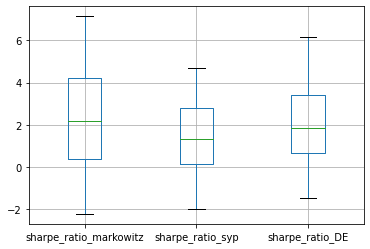

In [217]:
shape_mark_syp_DE_df[['sharpe_ratio_markowitz','sharpe_ratio_syp', 'sharpe_ratio_DE']].boxplot()

In [218]:
rendimientos_acu = shape_mark_syp_DE_df[['retorno_anual_markowitz','retorno_anual_syp', 'retorno_anual_DE']]
rendimientos_acu['retorno_trim_markowitz'] = rendimientos_acu['retorno_anual_markowitz'].apply(year2trim)
rendimientos_acu['retorno_trim_syp'] = rendimientos_acu['retorno_anual_syp'].apply(year2trim)
rendimientos_acu['retorno_trim_DE'] = rendimientos_acu['retorno_anual_DE'].apply(year2trim)
rendimientos_acu['retorno_trim_acum_markowitz'] = (rendimientos_acu['retorno_trim_markowitz']+1).cumprod()
rendimientos_acu['retorno_trim_acum_syp'] = (rendimientos_acu['retorno_trim_syp']+1).cumprod()
rendimientos_acu['retorno_trim_acum_DE'] = (rendimientos_acu['retorno_trim_DE']+1).cumprod()

<ipython-input-218-fe18ec28c806>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rendimientos_acu['retorno_trim_markowitz'] = rendimientos_acu['retorno_anual_markowitz'].apply(year2trim)
<ipython-input-218-fe18ec28c806>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rendimientos_acu['retorno_trim_syp'] = rendimientos_acu['retorno_anual_syp'].apply(year2trim)
<ipython-input-218-fe18ec28c806>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

In [219]:
rendimientos_acu.shape

(23, 9)

<AxesSubplot:title={'center':'Crecimiento del capital invertido'}, xlabel='trimeste_inicia'>

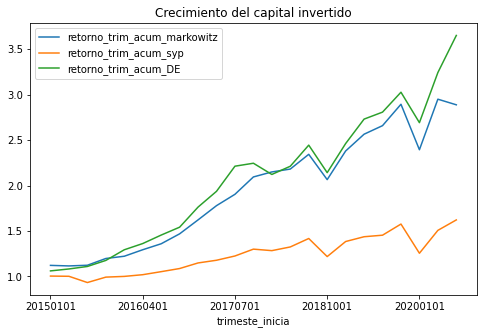

In [220]:
rendimientos_acu[['retorno_trim_acum_markowitz','retorno_trim_acum_syp', 'retorno_trim_acum_DE']].plot(figsize=(8, 5), title='Crecimiento del capital invertido')

In [221]:
rendimientos_acu.iloc[22:23]['retorno_trim_acum_syp'].to_list()[0]

1.621913603598403

In [222]:
print (f"Final Waelth for S&P: {rendimientos_acu.iloc[22:23]['retorno_trim_acum_syp'].to_list()[0]}")
print (f"Final Waelth for MV-MaxSharpe: {rendimientos_acu.iloc[22:23]['retorno_trim_acum_markowitz'].to_list()[0]}")
print (f"Final Waelth for 130/30 DE: {rendimientos_acu.iloc[22:23]['retorno_trim_acum_DE'].to_list()[0]}")

Final Waelth for S&P: 1.621913603598403
Final Waelth for MV-MaxSharpe: 2.8874253091821607
Final Waelth for 130/30 DE: 3.649977000864295
